In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from itertools import chain
import scipy.misc
import scipy.signal
from scipy import ndimage
import time
import os
import pickle
from matplotlib.colors import LogNorm

!jupyter nbconvert --to script event_converter.ipynb
import event_converter
from event_converter import *
reload(event_converter)

[NbConvertApp] Converting notebook event_converter.ipynb to script
[NbConvertApp] Writing 2675 bytes to event_converter.py


<module 'event_converter' from 'event_converter.pyc'>

In [4]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;
// this cell fixes the scroll boxes that are otherwise quite irritating

<IPython.core.display.Javascript object>

In [5]:
def cluster_positions_for_event(event, plot=False):
    positions = []
    def process_cluster_xy(val, pos):
        x = pos / event.shape[1]
        y = pos % event.shape[1]
        x1 = np.min(x)
        x2 = np.max(x)
        y1 = np.min(y)
        y2 = np.max(y)
        positions.append((x1, y1, x2, y2))
        return 1
    
    #timing_start()
    labeled_array, num_features = ndimage.label(event)
    #print timing_end()
    labels = np.arange(1, num_features+1)
    
    #timing_start()
    ndimage.labeled_comprehension(event, labeled_array, labels, process_cluster_xy, int, 0, True)
    #print timing_end()
    
    if plot:
        #show_gray(event, 'Event')
        hits = np.array(np.where(event == 1))
        hits = np.rollaxis(hits, 1)
        plt.figure(figsize=(14, 7))
        plt.scatter(hits[:,1], hits[:,0], s=5, c=np.array(labeled_array[np.where(event == 1)])*100, edgecolors='face')
    return np.array(positions)

def cluster_sizes(positions):
    return np.vstack([positions[:, 2] - positions[:, 0] + 1, positions[:, 3] - positions[:, 1] + 1]).T

def cl_pos_path_and_filename(eta, phi):
    return ('data/cluster_positions/' + str(eta) + '/', str(phi) + '.dat')

def load_cluster_positions(eta, phi):
    path, filename = cl_pos_path_and_filename(eta, phi)
    hits = get_hits(eta, phi)
    events = list(np.unique(hits[2,:]))
    cl_positions = dict()
    for eventID in events:
        event = get_hit_image(hits, eventID)
        positions = cluster_positions_for_event(event)
        cl_positions[eventID] = np.array(positions)
    if not os.path.exists(path):
        os.makedirs(path)
    outfile = open(path + filename, 'wb')
    pickle.dump(cl_positions, outfile, protocol=pickle.HIGHEST_PROTOCOL)
    outfile.close()
    return cl_positions

def cluster_positions(eta, phi):
    path, filename = cl_pos_path_and_filename(eta, phi)
    if not os.path.exists(path + filename):
        return load_cluster_positions(eta, phi)
    else:
        infile = open(path + filename, 'r')
        data = pickle.load(infile)
        infile.close
        return data
    
def cluster_sizes_for_eta(eta):
    print 'eta:', eta, 'phi:',
    sizes = np.zeros((0,2))
    for phi_i in range(0, 16):
        print phi_i,
        cl_positions = cluster_positions(eta, phi_i)
        for eventID, positions in cl_positions.iteritems():                
            sz = cluster_sizes(positions)
            sizes = np.vstack([sizes, sz])
    print
    return sizes

def mean_size_for_module(eta, phi):
    cl_positions = cluster_positions(eta, phi)
    sizes = np.zeros((0,2))
    for eventID, positions in cl_positions.iteritems():                
        sz = cluster_sizes(positions)
        sizes = np.vstack([sizes, sz])
    return np.mean(sizes, axis=0)

def mean_sizes_for_event(eta, phi):
    cl_positions = cluster_positions(eta, phi)
    sizes = np.zeros((0,2))
    for eventID, positions in cl_positions.iteritems():                
        sz = cluster_sizes(positions)
        sizes = np.vstack([sizes, np.mean(sz, axis=0)])
    return sizes

In [6]:
def hit_histogram(eta_from, eta_to):    
    bins = np.linspace(1,200,200)
    histogram_vertical = np.zeros(199)
    histogram_horizontal = np.zeros(199)

    num_events = 0
    num_hits = 0

    for phi_i in range(0, 16):
        print 'phi: ', phi_i, 'eta: ',
        for eta_i in range(eta_from, eta_to+1):
            print eta_i,
            #timing_start()
            hits = get_hits(eta_i, phi_i)
            events = list(np.unique(hits[2,:]))
            #print timing_end(),

            ti, th = 0, 0
            for eventID in events:
                timing_start()
                event = get_hit_image(hits, eventID)
                ti += timing_end()
                
                timing_start()
                hist, _ = np.histogram(np.sum(event, axis=1), bins = bins)
                histogram_horizontal += hist
                hist, _ = np.histogram(np.sum(event, axis=0), bins = bins)
                histogram_vertical += hist
                th += timing_end()

                num_events += 1
                num_hits += np.sum(event)
            #print ti, th
        print
    return (histogram_horizontal, histogram_vertical, num_hits, num_events)

def cons_hit_histogram(eta_from, eta_to):    
    bins = np.linspace(1,200,200)
    histogram_vertical = np.zeros(199)
    histogram_horizontal = np.zeros(199)

    num_events = 0
    num_hits = 0

    for phi_i in range(0, 16):
        print 'phi: ', phi_i, 'eta: ',
        for eta_i in range(eta_from, eta_to+1):
            print eta_i,
            #timing_start()
            cl_positions = cluster_positions(eta_i, phi_i)
            #print timing_end(),

            th = 0
            for eventID, positions in cl_positions.iteritems():                
                timing_start()
                sizes = cluster_sizes(positions)
                hist, _ = np.histogram(sizes[:,1], bins = bins)
                histogram_horizontal += hist
                hist, _ = np.histogram(sizes[:,0], bins = bins)
                histogram_vertical += hist
                th += timing_end()

                num_events += 1
                num_hits += len(sizes)*np.mean(sizes)
            #print th
        print
    return (histogram_horizontal, histogram_vertical, num_hits, num_events)

In [7]:
def plot_histograms(hor_hist, vert_hist, title, filename, x_lim=120, x_label='# Hits'):
    plt.figure(figsize=(14, 7))
    plt.plot(hor_hist, label = 'Hits per row')
    plt.plot(vert_hist, label = 'Hits per column')
    plt.xlim((0,x_lim))
    plt.legend(loc='upper right')
    plt.title(title)
    plt.ylabel('Count')
    plt.xlabel(x_label)
    plt.yscale('log')
    plt.xticks(np.linspace(0, 120, 31))
    plt.grid(True)
    plt.savefig(filename)
    

In [8]:
def show_hit_historgram(eta1, eta2):
    h_horizontal, h_vertical, num_hits, num_events = hit_histogram(eta1, eta2)

    title = 'Number of hits per column/row per event for modules in barrel, layer=0, etaModule=' + str(eta1) + '-' + str(eta2)
    plot_histograms(h_horizontal/num_hits, h_vertical/num_hits, title, 'hits_hist_' + str(eta1) + '-' + str(eta2) + '.png')
    
#show_hit_historgram(14, 16)

In [9]:
def show_cons_hit_histogram(eta1, eta2):
    h_horizontal, h_vertical, num_hits, num_events = cons_hit_histogram(eta1, eta2)

    title = 'Length of a consecutive run of hits per event for modules in barrel, layer=0, etaModule=' + str(eta1) + '-' + str(eta2)
    plot_histograms(h_horizontal/num_hits, h_vertical/num_hits, title, 'hits_hist_cons_' + str(eta1) + '-' + str(eta2) + '.png')
    
#show_cons_hit_histogram(14, 16)

In [10]:
def show_size_heatmap_per_eta(eta1, eta2):
    eta_sizes = {}
    for eta_i in range(eta1, eta2+1):
        eta_sizes[eta_i] = cluster_sizes_for_eta(eta_i)

    plt.figure(figsize=(25, 75))
    for eta_i in range(eta1, eta2+1):
        sizes = eta_sizes[eta_i]
        plt.subplot(30, 1, eta_i)
        plt.title('Cluster size in eta vs phi for etaModule=' + str(eta_i))
        H, yedges, xedges = np.histogram2d(sizes[:, 0], sizes[:, 1], bins=(range(1, 10), range(1, 120)))
        norm = LogNorm(1, H.max())
        plt.imshow(np.clip(H, 1, H.max()), norm=norm, cmap="gray", interpolation='nearest', origin='low', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
        plt.colorbar()
    plt.savefig('cluster_size_heat_2.png')
    
#show_size_heatmap_per_eta(1, 30)

In [11]:
from math import *

def module_pixel_to_eta(eta_i, pixel_i):
    height = 336
    zi = 0.2 + 40.9 * (eta_i - 1)
    zo = 0.2 + 40.9 * (eta_i - 1) + 40.5
    r = 65
    ti = atan(r/zi)
    to = atan(r/zo)
    etai = -log(tan(ti/2))
    etao = -log(tan(to/2))
    return etai + (etao - etai)*(pixel_i-1)/(height-1)

def np_module_pixel_to_theta(eta_i, pixel_i):
    height = 336
    zi = 0.2 + 40.9 * (eta_i - 1)
    zo = 0.2 + 40.9 * (eta_i - 1) + 40.5
    r = 65
    ti = np.arctan(r/zi)
    to = np.arctan(r/zo)
    return ti + (to - ti)*(pixel_i-1)/(height-1)

def np_module_pixel_to_eta(eta_i, pixel_i):
    height = 336
    ti = np_module_pixel_to_theta(eta_i, 1)
    to = np_module_pixel_to_theta(eta_i, height)
    etai = -np.log(np.tan(ti/2))
    etao = -np.log(np.tan(to/2))
    return etai + (etao - etai)*(pixel_i-1)/(height-1)

eta: 1 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 2 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 3 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 4 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 5 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 6 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 7 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 8 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 9 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 10 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 11 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 12 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 13 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 14 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 15 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 16 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 17 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 18 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 19 phi: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
eta: 20 phi: 0 1 2 3 4 5 6 7 8 9 10 11 1

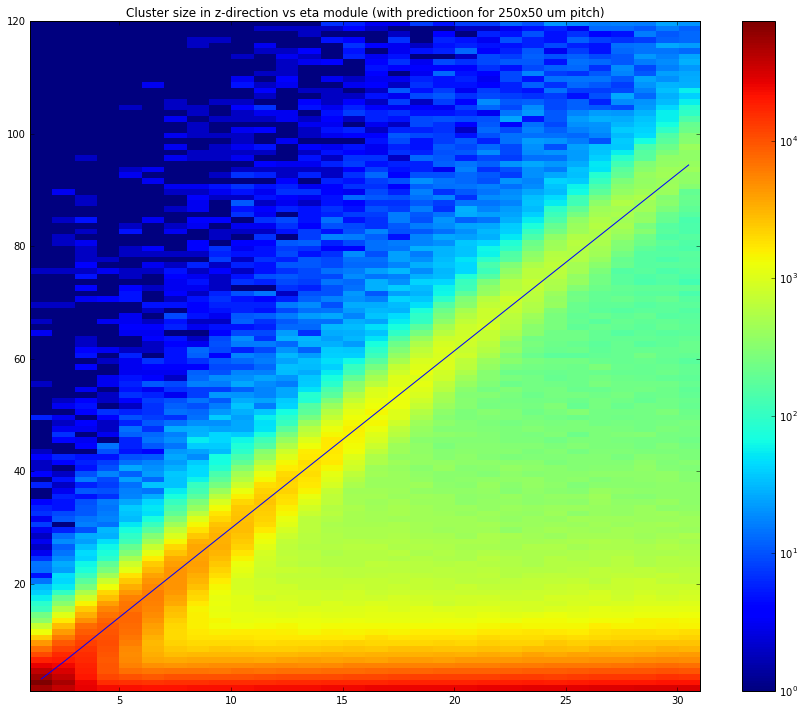

In [12]:
def show_length_heatmap_per_eta(eta1, eta2):
    eta_lengths = []
    for eta_i in range(eta1, eta2+1):
        sizes = cluster_sizes_for_eta(eta_i)
        sizes[:, 0] = eta_i
        eta_lengths.append(sizes)

    eta_lengths = np.vstack(eta_lengths)

    plt.figure(figsize=(15, 12))
    plt.title('Cluster size in z-direction vs eta module (with predictioon for 250x50 um pitch)')
    H, yedges, xedges = np.histogram2d(eta_lengths[:, 1], eta_lengths[:, 0], bins=(range(1, 121), range(1, 32)))
    norm = LogNorm(1, H.max())
    plt.imshow(np.clip(H, 1, H.max()), norm=norm, aspect=0.25, interpolation='nearest', origin='low', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
    plt.colorbar()
    plt.axis('tight')

    eta_i = np.linspace(1, 30, 30)
    theta = np_module_pixel_to_theta(eta_i, 186)
    length = 250/(50*np.tan(theta))+1
    plt.plot(eta_i+0.5, length+0.5)

    plt.savefig('cluster_length_eta.png')

show_length_heatmap_per_eta(1, 30)
    
# TODO: split based on ToT - low/high energy

In [13]:
def show_scatter_sizes_per_event():
    plt.figure(figsize=(14, 16))

    colors = plt.cm.rainbow(np.linspace(0, 1, 31))

    print 'eta: ',
    for eta_i in range(30, 0, -1):
        print eta_i,
        sizes = np.vstack([mean_sizes_for_event(eta_i, phi_i) for phi_i in range(16)])
        x_values = sizes[:, 1]
        y_values = sizes[:, 0]
        plt.scatter(x_values, y_values, c=colors[eta_i], label='eta=' + str(eta_i), edgecolors='face')

    plt.legend(loc='lower right')

    plt.title('Mean consecutive hit length along eta vs phi per event')
    plt.ylabel('Mean consecutive hit length along phi')
    plt.xlabel('Mean consecutive hit length along eta')
    plt.grid(True)
    plt.savefig('scatter_cons_per_event.png')
    
#show_scatter_sizes_per_event()

In [14]:
def show_scatter_sizes_per_module():
    plt.figure(figsize=(14, 16))

    colors = plt.cm.rainbow(np.linspace(0, 1, 31))

    print 'eta: ',
    for eta_i in range(30, 0, -1):
        print eta_i,
        sizes = np.array([mean_size_for_module(eta_i, phi_i) for phi_i in range(16)])
        x_values = sizes[:, 1]
        y_values = sizes[:, 0]
        plt.scatter(x_values, y_values, c=colors[eta_i], label='eta=' + str(eta_i), edgecolors='face')

    plt.legend(loc='lower right')

    plt.title('Mean consecutive hit length along eta vs phi per module')
    plt.ylabel('Mean consecutive hit length along phi')
    plt.xlabel('Mean consecutive hit length along eta')
    plt.grid(True)
    plt.savefig('scatter_cons_per_module.png')
    
#show_scatter_sizes_per_module()